# Python в инженерных расчетах. Лекция 08.
<hr style="border:2px solid gray">

#### План занятия:
1. **Модель напряжения течения Хензеля-Шпиттеля**
2. **Оцифровка данных с помощью WebPlotDigitizer. Чтение данных в json формате**
3. **Апроксимация данных уравнением Хензеля-Шпиттеля**
4. **Оценка качества полученных результатов** 

In [157]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import json # библиотека для работы с файлами json (JavaScript Object Notation)
from Lection_006 import Data_xy
from scipy.optimize import curve_fit

# Кривая деформационного упрочнения сплава ОТ4-1*
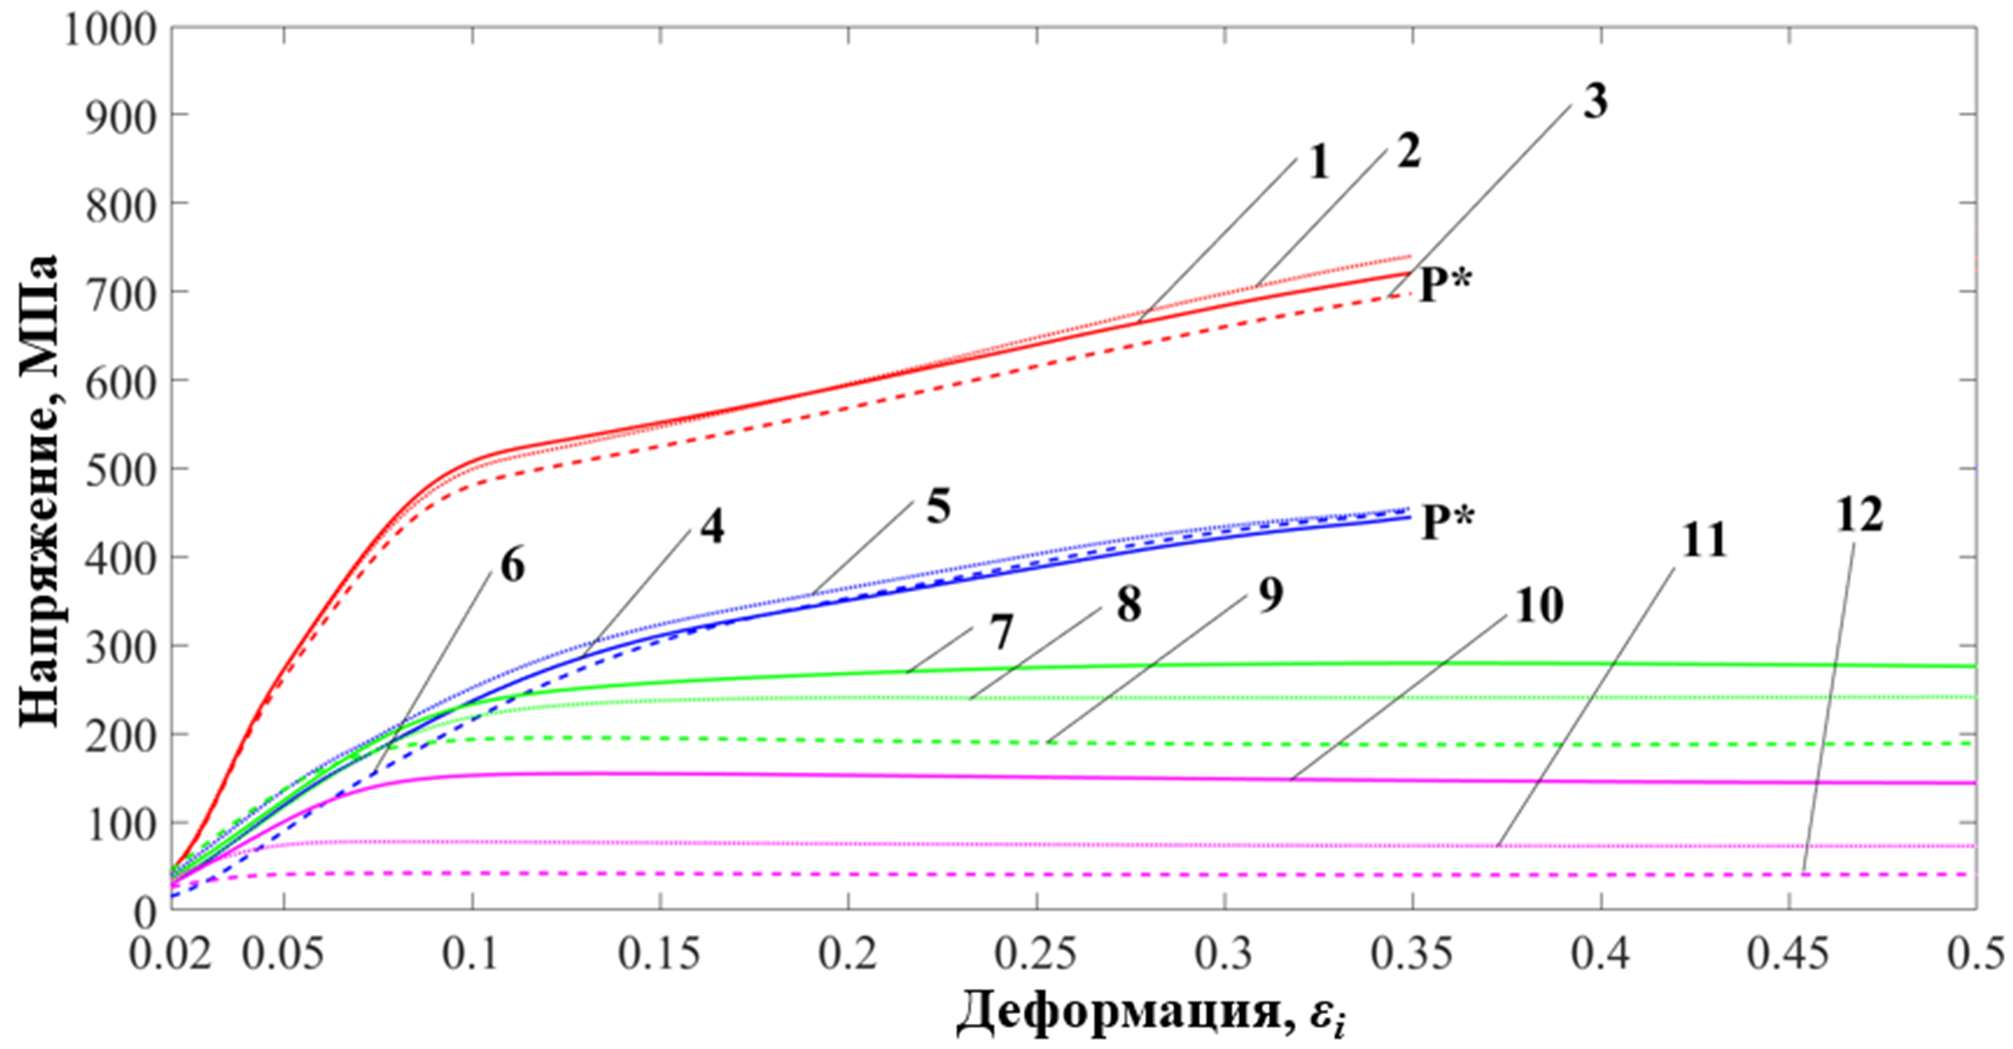

1, 2, 3 – при температуре 20 °C и скоростях деформаций 0.4; 0.01; 0.001 с⁻¹,  
4, 5, 6 – при температуре 400 °C и скоростях деформаций 0.4; 0.01; 0.001 с⁻¹,  
7, 8, 9 – при температуре 600 °C и скоростях деформаций 0.4; 0.01; 0.001 с⁻¹,  
10, 11, 12 – при температуре 800 °C и скоростях деформаций 0.4; 0.01; 0.001 с⁻¹,  
Р* - разрушение образца

* *Нгуен, Х. Т. Управление процессами формообразования заготовок из титановых сплавов (на примере сплава от4-1) с использованием моделирования реологии и режимов деформирования / П. А. Петров, Х. Т. Нгуен, И. А. Бурлаков, Р. Ю. Сухоруков // Проблемы машиностроения и надежности машин. – 2021. – No 6. – С. 88-95. – DOI 10.31857/S0235711921060134. – EDN RDSVXV.

# 1. Модель напряжения течения Хензеля-Шпиттеля.

<div style="font-size: 18px; line-height: 1.6;">

$$
\large
\sigma_f = A \cdot e^{m_1 T} \cdot T^{m_9} \cdot \varepsilon^{m_2} \cdot e^{\frac{m_4}{\varepsilon}} \cdot (1 + \varepsilon)^{m_5 T} \cdot e^{-m_6 \varepsilon} \cdot \dot{\varepsilon}^{m_3} \cdot \dot{\varepsilon}^{m_7 T}
$$

**где:**  
- $\sigma_f$ - напряжение течения материала  
- $\varepsilon$ - истинная деформаци  
- $\dot{\varepsilon}$ - скорость деформации  
- $T$ - температура 
- $A$ - эмпирический коэффициент, опредделяемый экспериментально  
- $m_1, m_2, ..., m_9$ - эмпирические коэффициенты, определяемые экспериментально

</div>


In [158]:
# функция для уравнения Хензеля–Шпиттеля
def hensel_spittel(T, eps, eps_dot, A, m1, m2, m3, m4, m5, m6, m7, m9):
    """Вычисляет напряжение течения по эмпирической модели Хензеля–Шпиттеля. 
    Args:
        T (array_like): Абсолютная температура, К.
        eps (array_like): Истинная (логарифмическая) степень деформации (должна быть > 0).
        eps_dot (array_like): Скорость деформации, с⁻¹ (должна быть > 0).
        A (float): Материалозависимая константа, МПа.
        m1, m2, ..., m9 (float): Эмпирические коэффициенты модели (безразмерные, кроме A).
    Returns:
        array_like: Напряжение течения σ_f, МПа.
    """
    term1 = A
    term2 = np.exp(m1 * T)
    term3 = T**m9
    term4 = eps**m2
    term5 = np.exp(m4 / eps)
    term6 = (1 + eps)**(m5 * T)
    term7 = np.exp(-m6 * eps)
    term8 = eps_dot**m3
    term9 = eps_dot**(m7 * T)
    return term1 * term2 * term3 * term4 * term5 * term6 * term7 * term8 * term9

## Значения коэффициентов Хензеля-Шпиттеля по материалам *
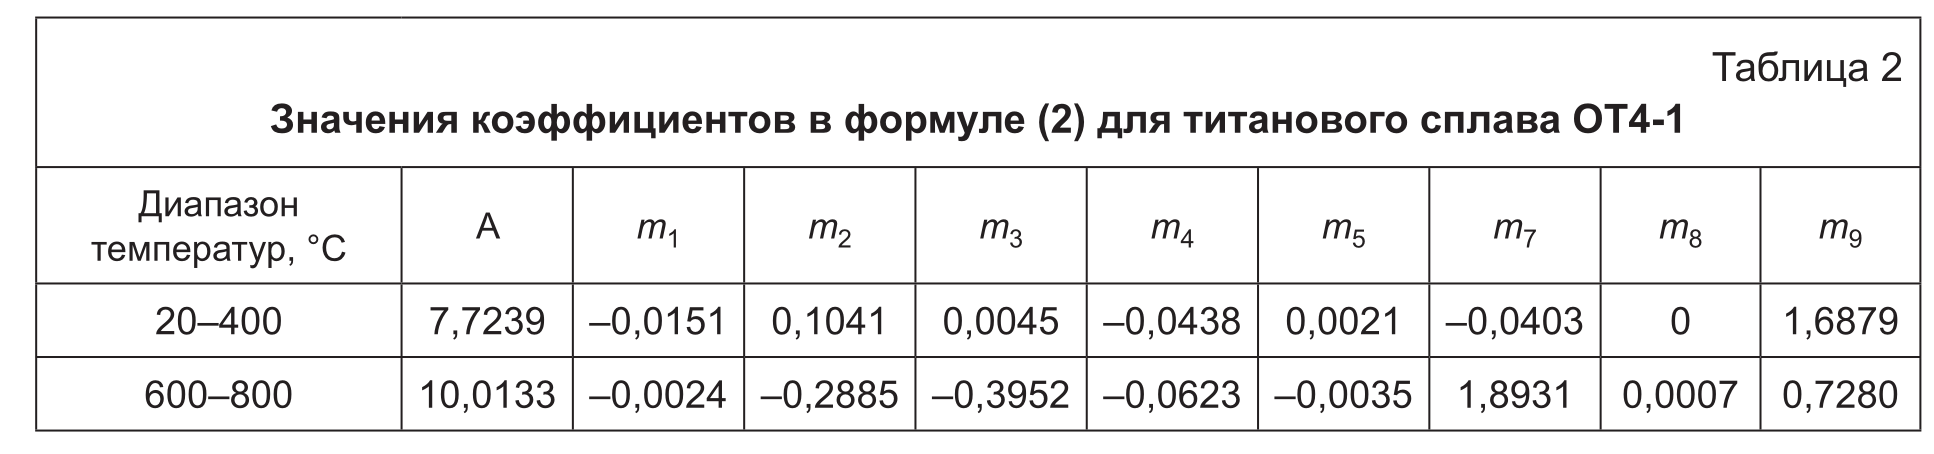

*  *Нгуен, Х. Т. Управление процессами формообразования заготовок из титановых сплавов (на примере сплава от4-1) с использованием моделирования реологии и режимов деформирования / П. А. Петров, Х. Т. Нгуен, И. А. Бурлаков, Р. Ю. Сухоруков // Проблемы машиностроения и надежности машин. – 2021. – No 6. – С. 88-95. – DOI 10.31857/S0235711921060134. – EDN RDSVXV.


In [174]:
# Проверим работоспособность модели

# коэффициенты уравнения Хензеля–Шпиттеля для сплава ОТ4-1 
A, m1, m2, m3, m4, m5, m6, m7, m9 = 10.0133, -0.0024, -0.2885, -0.3952,	-0.0623, -0.0035, 1.8931, 0.0007, 0.7280


# Значения температуры, деформации и скорсоти деформации
T, strain, strain_rate = 800, 0.2, 0.4
flow_stress = hensel_spittel(T, eps, eps_dot, A, m1, m2, m3, m4, m5, m6, m7, m9)
print (f'Напряжение течения при заданных параметрах: {flow_stress:.2f}, МПа')

Напряжение течения при заданных параметрах: 29.24, МПа


# 2. Отцифровка данных с помощью WebPlotDigitizer. Чтение данных в json формате.

Т.к. полученная автором модель явно работает не очень хорошо, попробуем на тех же данных получить свои собственные коэффициенты.   
Воспользуемся утилитой для оцифровки данных утилитой [WebPlotDigitizer](https://automeris.io/).   


Для обработки данных создадим два класса:       
1. Curve - для хранения идиничной кривой;   
2. SetOfCurves - для хранения семейства кривых в формате Curve и для апроксимации этого семейства уравнением Хензеля-Шпиттеля.

In [160]:
class Curve (Data_xy):
    '''
    Класс для хранения кривой сопротивления пластической деформации
    '''
    def __init__(self, x_data, y_data, temperature, strain_rate, colour, data_name='Default data', line_type = '-'):
        super().__init__(x_data, y_data, data_name)
        
        self.colour = np.array(colour) / 255.0
        self.line_type = line_type
        
        self.temperature = temperature
        self.strain_rate = strain_rate
        
    @property
    def strain (self): 
        return self.x_data
    @property
    def stress (self): 
        return self.y_data
    @property
    def curve_name (self):
        return self.data_name


In [161]:
class SetOfCurves:
    '''
    Класс для хранения семейства кривых сопротивления пластической дефомрации
    '''
    def __init__(self, dict_of_curves):
        self.curves = dict_of_curves
        self.line_types = ['-', '--', ':', '*', 'x', 'o', '-.']
        
    def get_all_process_conditions (self):
        '''
        собирает все температуры, деформации, скорости деформации и напряжения
        в один массив
        '''
        temps = []
        strain_rates = []
        strains = []
        stresses = []
        
        for curve in self.curves.values():
            for i in range(len(curve.strain)):
                temps.append(curve.temperature)
                strain_rates.append(curve.strain_rate)
                strains.append(curve.strain[i])
                stresses.append(curve.stress[i])
        
        self.data = np.array([temps, strain_rates, strains, stresses]).T
        
        return self.data

In [162]:
# Загрузка кривых сопротивления пластической деформации из JSON-файла
with open('../data/OT4_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [163]:
# посмотрим на данные
data

{'version': [4, 2],
 'axesColl': [{'name': 'XY',
   'type': 'XYAxes',
   'isLogX': False,
   'isLogY': False,
   'noRotation': False,
   'calibrationPoints': [{'px': 284.3220338983051,
     'py': 908.882768361582,
     'dx': '0.05',
     'dy': '0',
     'dz': None},
    {'px': 1976.0381355932204,
     'py': 908.882768361582,
     'dx': '0.5',
     'dy': '0',
     'dz': None},
    {'px': 170.59322033898306,
     'py': 908.882768361582,
     'dx': '0.05',
     'dy': '0',
     'dz': None},
    {'px': 172.48870056497177,
     'py': 201.86864406779662,
     'dx': '0.5',
     'dy': '800',
     'dz': None}]}],
 'datasetColl': [{'name': '20 0.4',
   'axesName': 'XY',
   'colorRGB': [200, 0, 0, 255],
   'metadataKeys': [],
   'data': [{'x': 172.48870056497177,
     'y': 870.973163841808,
     'value': [0.02022506589767275, 42.89544235924927]},
    {'x': 291.90395480225993,
     'y': 658.6793785310734,
     'value': [0.0518383761011107, 283.10991957104557]},
    {'x': 404.68502824858757,
     'y

In [164]:
# Создаём словарь куда будем записывать кривые
curves = {}
# создадим множество куда будем записывать скорости деформации и температуры на которых определены кривые
strain_rates = set()
temperatures = set()

In [165]:
# считываем все необходимые нам данные из словаря data
for dataset in data['datasetColl']:
    name = dataset['name']  # имя кривой, например: "20 0.4" (20 градусов при скорости деформации 0.5 1/с)
    colour = dataset['colorRGB']
    points = dataset['data']  # список точек входящих в данную кривую
    temperature, strain_rate = name.split() # извлечем из имени кривой данные о температуре и скорости деформации
    temperature = float(temperature)
    strain_rate = float(strain_rate)
    strain_rates.add(round(strain_rate, 5))
    temperatures.add(round(temperature, 1))
        
    # Извлекаем значения [деформация, напряжение] и конвертируем в numpy массив
    values = [point['value'] for point in points]  # список списков
    xy_data = np.array(values) # массив координат
        
    # создаем объект класса Curve
    curve = Curve (xy_data[:, 0], xy_data[:, 1], temperature, strain_rate, colour, data_name=name)
    # добавляем его в словарь curves
    curves[name] = curve

In [166]:
# создаем объект класса SetOfCurves 
curves_object = SetOfCurves (curves)
# собираем все данные по температуре, скорости деформации, деформации и напряжению в массив NumPy
data_array = curves_object.get_all_process_conditions()
data_array[:10, :]

array([[2.00000000e+01, 4.00000000e-01, 2.02250659e-02, 4.28954424e+01],
       [2.00000000e+01, 4.00000000e-01, 5.18383761e-02, 2.83109920e+02],
       [2.00000000e+01, 4.00000000e-01, 8.17295605e-02, 4.55764075e+02],
       [2.00000000e+01, 4.00000000e-01, 1.02367360e-01, 5.10455764e+02],
       [2.00000000e+01, 4.00000000e-01, 1.51753441e-01, 5.51206434e+02],
       [2.00000000e+01, 4.00000000e-01, 2.51024399e-01, 6.41286863e+02],
       [2.00000000e+01, 4.00000000e-01, 3.48538085e-01, 7.19571046e+02],
       [2.00000000e+01, 1.00000000e-02, 2.02243900e-02, 4.39678284e+01],
       [2.00000000e+01, 1.00000000e-02, 5.23378467e-02, 2.90616622e+02],
       [2.00000000e+01, 1.00000000e-02, 8.12321175e-02, 4.45040214e+02]])

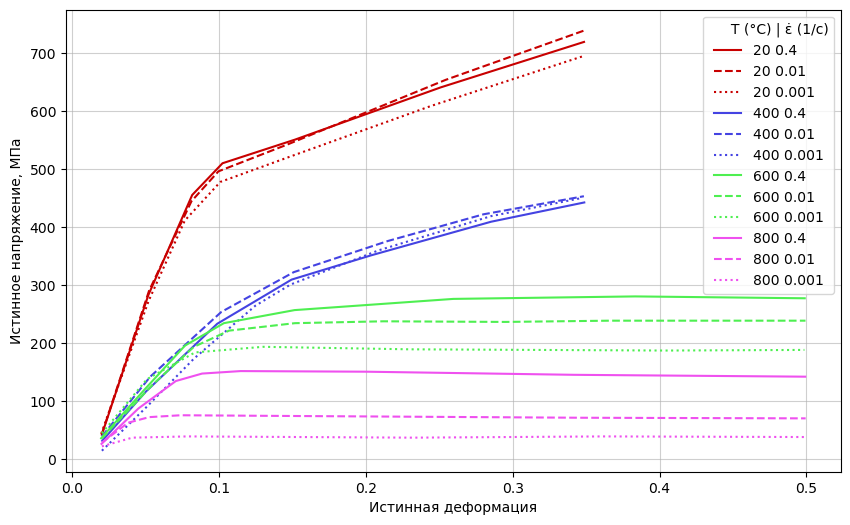

In [167]:
# Посмотри на данные

# Настройка графика
plt.figure(figsize=(10, 6))

# будем итерировать по словарю
for curve in curves.values():
    # найдем номер скорости деформации из множества strain_rates 
    indx = list(strain_rates).index(curve.strain_rate)    
    # в соответсвии с этим номером назначим тип кривой. Список с типами кривой является 
    # атрибутом объекта класса SetOfCurves (т.е. объекта curves_object)
    curve.line_type = curves_object.line_types[indx]
                
    plt.plot (curve.strain, curve.stress, color = curve.colour, linestyle =curve.line_type,  label = curve.curve_name)

# Оформление
plt.xlabel('Истинная деформация')
plt.ylabel('Истинное напряжение, МПа')
plt.grid(True, alpha=0.6)
plt.legend(title='     T (°C) | ε̇ (1/с)')

# 3. Апроксимация данных уравнением Хензеля-Шпиттеля

### Добавим к класс SetOfCurves два статических метода:
1. Собственно само уравение Хензеля-Шпиттеля (функция hensel_spittel);
2. Обертку, которая позволит подставлять уравнение в метод curve_fit (функция model).

In [168]:
# уравение Хензеля-Шпиттеля
SetOfCurves.hensel_spittel = staticmethod(hensel_spittel)

# Обертка
def model(X, A, m1, m2, m3, m4, m5, m6, m7, m9):
    T, strain_rate, strain = X
    return SetOfCurves.hensel_spittel(T, strain, strain_rate, A, m1, m2, m3, m4, m5, m6, m7, m9)
SetOfCurves.model = staticmethod(model)

In [169]:
# Попытка расчета коэффициентов уравнения 
X = (data_array[:, 0], data_array[:, 1], data_array[:, 2])
stress = data_array[:, 3]
    
# начальное приблечене значения коэффициентов (см таблицу из статьи)
p0 = [10.0133, -0.0024, -0.2885, -0.3952, -0.0623, -0.0035, 1.8931, 0.0007, 0.7280]

# расчет коэффицинтов
popt, pcov = curve_fit(SetOfCurves.model, X, stress, p0=p0)

print("Оптимальные коэффициенты:")
params = ['A', 'm1', 'm2', 'm3', 'm4', 'm5', 'm7', 'm9']
for name, val in zip(params, popt):
    print(f"  {name} = {val:.6g}")

Оптимальные коэффициенты:
  A = 300.214
  m1 = -0.00250981
  m2 = -0.175403
  m3 = 0.000299699
  m4 = -0.0628002
  m5 = -0.0014296
  m7 = -0.870528
  m9 = 6.83596e-05


# 4. Оценка качества полученных результатов
### Результаты расчета будем оценивать двумя способами:
1. С помощью графика паритета;
2. С помощью коэффициента детерминации.

### Коэффициент детерминации $ R^2 $

Метрика, показывающая долю дисперсии зависимой переменной, объяснённую моделью:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

где:  
- $ y_i $ — истинные значения,  
- $ \hat{y}_i $ — предсказанные моделью значения,  
- $ \bar{y} $ — среднее истинных значений.

Чем ближе $ R^2 $ к 1, тем лучше модель описывает данные.

In [170]:
# напишем функцию для расчета коэффициента детерминации и добавим ее в качестве статического метода
# в класс SetOfCurves
def r2_score(y_true, y_pred):
    '''
    Расчет коэффициента детерминации
    '''    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0

SetOfCurves.r2_score = staticmethod(r2_score)

In [171]:
# Посчитаем модельные значение
sigma_pred = SetOfCurves.model(X, *popt)
# Выделим истинное значение
# Истинные (экспериментальные) значения
sigma_true = stress
# Посчитаем коэффициент детерминации
R2 = SetOfCurves.r2_score(sigma_true, sigma_pred)
print (f'R² = {R2}')

R² = 0.9678263873461103


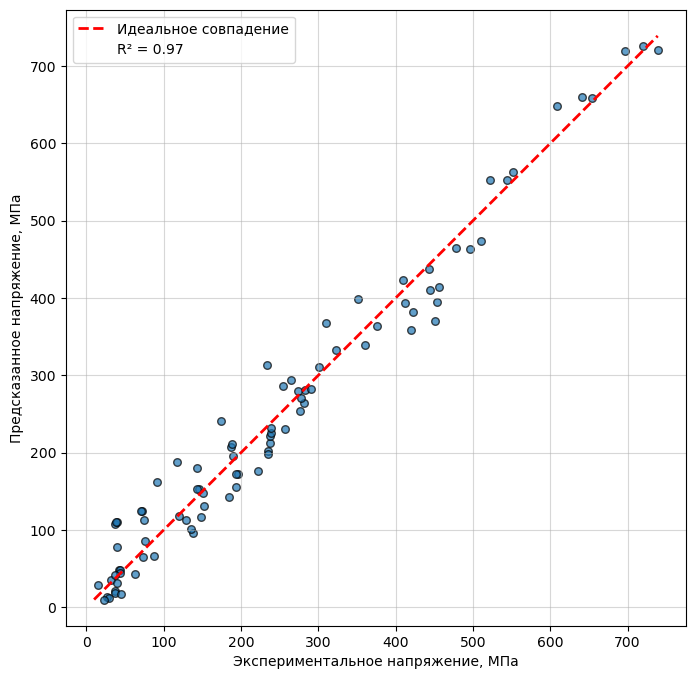

In [173]:
# Построи график паритета
# Диапазон для линии y = x
min_val = min(sigma_true.min(), sigma_pred.min())
max_val = max(sigma_true.max(), sigma_pred.max())


plt.figure(figsize=(8, 8))
plt.scatter(sigma_true, sigma_pred, alpha=0.7, edgecolors='k', s=30)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальное совпадение')
plt.plot ([], [], ' ', label = f'R² = {R2:.2f}')
    
plt.xlabel('Экспериментальное напряжение, МПа')
plt.ylabel('Предсказанное напряжение, МПа')
plt.legend()
plt.grid(True, alpha=0.5)
plt.axis('equal');  # чтобы угол был именно 45°